# **Notebook setup**



In [ ]:
pip install tqdm

In [ ]:
pip install scikit-image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Folder containing images
image_folder = '/content/drive/My Drive/Colab Notebooks/data/HAM10000/HAM10000_images'

# Count the number of image files in the folder
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  # Add more extensions if needed
image_count = sum(len(files) for _, _, files in os.walk(image_folder) if any(file.endswith(tuple(image_extensions)) for file in files))

print(f"Number of images in the folder: {image_count}")


Number of images in the folder: 10015


In [ ]:
# Path to your CSV file
csv_file_path = '/content/drive/My Drive/Colab Notebooks/data/HAM10000/HAM10000_metadata.csv'

# Count the number of rows in the CSV file
with open(csv_file_path, 'r') as file:
    reader = csv.reader(file)
    row_count = sum(1 for row in reader)

print(f"Number of rows in the CSV file: {row_count}")


NameError: ignored

# **Import libraries**

In [ ]:
# General
import os, pickle
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np

import cv2
from PIL import Image

import matplotlib.pyplot as plt

from multiprocessing import Pool

import skimage
# from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy

# **Define path**

In [ ]:
data_path = Path("/content/drive/My Drive/Colab Notebooks/data/HAM10000")
print(os.listdir(data_path))

['hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', 'HAM10000_metadata.csv', 'HAM10000_images']


# **Get data**

In [ ]:
csv_path = data_path / 'HAM10000_metadata.csv'
df_data=pd.read_csv(csv_path).set_index('image_id')
df_data.head()

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear


# **Exploratory Data Analysis**

In [ ]:
# Categories of the diferent diseases
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df_data.dx=df_data.dx.astype('category',copy=True)
df_data['label']=df_data.dx.cat.codes # Convert the labels to numbers
df_data['lesion_type']= df_data.dx.map(lesion_type_dict)
df_data.head()

,lesion_id,dx,dx_type,age,sex,localization,label,lesion_type
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,2,Benign keratosis


In [ ]:
# create key relating label to lesion_type
label_list = df_data['label'].value_counts().keys().tolist()
lesion_list = df_data['lesion_type'].value_counts().keys().tolist()
label_to_lesion = dict(zip(label_list, lesion_list))
label_to_lesion

{5: 'Melanocytic nevi',
 4: 'Melanoma',
 2: 'Benign keratosis ',
 1: 'Basal cell carcinoma',
 0: 'Actinic keratoses',
 6: 'Vascular lesions',
 3: 'Dermatofibroma'}

# **Preprocessing**

In [ ]:
# Function for resizing images
def resize_image(input_path, output_path, target_size):
    img = Image.open(input_path)
    img = img.resize(target_size, Image.ANTIALIAS)
    img.save(output_path)

In [ ]:
def remove_hair(input_image):
    # Load the input image
    image = cv2.imread(input_image)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Morphological Black-Hat transformation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # Create a mask for the inpainting task (you may need to adjust parameters)
    _, thresh = cv2.threshold(blackhat, 30, 255, cv2.THRESH_BINARY)

    # Apply inpainting algorithm on the original image using the mask
    cleaned_image = cv2.inpaint(image, thresh, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

    return cleaned_image

In [ ]:
def remove_noise(input_image):
    # Load the input image
    image = cv2.imread(input_image)

    # Apply Gaussian filtering to remove noise (adjust the kernel size and sigma as needed)
    denoised_image = cv2.GaussianBlur(image, (7, 7), 1)

    return denoised_image

In [ ]:
def grabcut_segmentation(input_image, threshold=0.9):
    # Load the input image
    image = cv2.imread(input_image)

    # Create a mask for GrabCut
    mask = np.zeros(image.shape[:2], np.uint8)

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Extract the green channel (assumption that skin lesions appear green)
    green_channel = hsv_image[:, :, 1]

    # Create a threshold mask based on the green channel
    mask[green_channel > 0] = 1  # 1 for foreground, 0 for background

     # Compute the area of the mask
    total_pixels = np.prod(mask.shape)
    lesion_pixels = np.sum(mask)
    mask_area = lesion_pixels / total_pixels

    # Check if the mask area exceeds the threshold
    if mask_area > threshold:
        # Generate a rectangle for GrabCut
        Hr = int(image.shape[0] - 0.3 * image.shape[0])
        Wr = int(image.shape[1] - 0.3 * image.shape[1])
        rect = (int(0.15 * image.shape[1]), int(0.15 * image.shape[0]), Wr, Hr)

        # Create a mask for GrabCut
        fg_model = np.zeros((1, 65), np.float64)
        bg_model = np.zeros((1, 65), np.float64)
        mask, bgdModel, fgdModel = cv2.grabCut(image, mask, rect, bg_model, fg_model, 5, cv2.GC_INIT_WITH_RECT)
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

        # Multiply the original image by the mask to get the segmented image
        segmented_image = image * mask2[:, :, np.newaxis]
    else:
        # Use the original image if the mask area is below the threshold
        segmented_image = image

    return segmented_image

In [ ]:
# Specify paths and parameters
input_folder = '/content/drive/My Drive/Colab Notebooks/data/HAM10000/HAM10000_images'
output_folder = '/content/drive/My Drive/Colab Notebooks/data/HAM10000/HAM10000_preprocessed'
target_size = (512, 512)

In [ ]:
def apply_preprocessing(input_image_path, output_folder, target_size, output_path):
    # Resize the image
    resized_path = os.path.join(output_folder, os.path.basename(input_image_path))
    resize_image(input_image_path, resized_path, target_size)

    # Apply hair removal
    cleaned_image = remove_hair(resized_path)

    # Apply noise removal
    denoised_image = remove_noise(cleaned_image)

    # Apply GrabCut segmentation
    segmented_image = grabcut_segmentation(denoised_image)

    # Save the processed image
    cv2.imwrite(output_path, segmented_image)

In [ ]:
import csv

metadata_path = '/content/drive/My Drive/Colab Notebooks/data/HAM10000/HAM10000_metadata.csv'
index_to_print = 3109

# Function to print a specific row in the CSV file
def print_specific_row(csv_file, index):
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        headers = next(reader)
        try:
            row_to_print = next(reader)
            for i, row in enumerate(reader):
                if i == index:
                    row_to_print = row
                    break
            print(row_to_print)
        except StopIteration:
            print("Index out of range.")

print_specific_row(metadata_path, index_to_print)

['HAM_0000047', 'ISIC_0027810', 'nv', 'follow_up', '50.0', 'female', 'trunk']


In [ ]:
# Specify paths and parameters
input_folder = '/content/drive/My Drive/Colab Notebooks/data/HAM10000/HAM10000_images'
output_folder = '/content/drive/My Drive/Colab Notebooks/data/HAM10000_preprocessed'
target_size = (512, 512)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through the images in the input folder
for filename in tqdm(os.listdir(input_folder), desc="Processing Images", unit="image"):
    if filename.endswith('.jpg'):
        input_image_path = os.path.join(input_folder, filename)
        output_image_path = os.path.join(output_folder, filename)

        # Check if the processed image already exists in the output folder
        if not os.path.exists(output_image_path):

            # Apply hair removal
            cleaned_image = remove_hair(input_image_path)

            # Apply noise removal
            denoised_image = remove_noise(input_image_path)

            # Apply GrabCut segmentation
            segmented_image = grabcut_segmentation(input_image_path)

            # Save the processed image
            cv2.imwrite(output_image_path, segmented_image)
        else:
            print(f"Skipping preprocessing for {filename}. Image already exists in the output folder.")

Processing Images:   3%|▎         | 330/10015 [00:00<00:06, 1596.58image/s]

Skipping preprocessing for ISIC_0033319.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033354.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033372.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033374.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033361.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033328.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033332.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033395.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033384.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033387.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033353.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:   6%|▌         | 619/10015 [00:00<00:13, 694.64image/s]

Skipping preprocessing for ISIC_0033808.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033794.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033816.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033804.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033817.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033842.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033780.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033797.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033801.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033847.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033798.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:   9%|▊         | 852/10015 [00:01<00:10, 854.57image/s]

Skipping preprocessing for ISIC_0034016.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034071.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034014.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034043.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034018.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034052.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034070.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034068.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034039.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034075.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034064.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  12%|█▏        | 1195/10015 [00:01<00:07, 1246.38image/s]

Skipping preprocessing for ISIC_0034294.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034277.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034262.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034259.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034274.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034314.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034307.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034306.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034310.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034318.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0034320.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  17%|█▋        | 1718/10015 [00:01<00:05, 1554.08image/s]

Skipping preprocessing for ISIC_0032694.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032689.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032667.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032682.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032714.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032713.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032657.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032648.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032699.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032647.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032710.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  21%|██        | 2072/10015 [00:01<00:04, 1615.09image/s]

Skipping preprocessing for ISIC_0033029.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033054.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033077.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033043.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033039.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033082.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033052.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033079.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033078.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033049.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0033047.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  25%|██▍       | 2479/10015 [00:01<00:04, 1813.20image/s]

Skipping preprocessing for ISIC_0031438.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031423.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031406.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031454.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031410.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031453.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031477.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031456.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031424.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031476.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031461.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  29%|██▊       | 2855/10015 [00:02<00:04, 1785.57image/s]

Skipping preprocessing for ISIC_0031883.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031852.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031871.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031909.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031879.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031904.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031848.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031914.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031851.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031854.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031896.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  32%|███▏      | 3238/10015 [00:02<00:03, 1846.25image/s]

Skipping preprocessing for ISIC_0032175.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032233.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032192.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032215.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032197.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032211.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032170.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032185.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032222.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032204.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0032173.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  36%|███▌      | 3624/10015 [00:02<00:03, 1873.52image/s]

Skipping preprocessing for ISIC_0030688.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030636.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030707.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030643.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030699.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030678.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030663.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030673.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030694.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030669.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030705.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  40%|████      | 4041/10015 [00:02<00:03, 1959.89image/s]

Skipping preprocessing for ISIC_0031064.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031000.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031001.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031036.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031028.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031057.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031007.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030994.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031018.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031062.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0031031.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  44%|████▍     | 4426/10015 [00:02<00:02, 1864.52image/s]

Skipping preprocessing for ISIC_0029557.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029496.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029502.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029533.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029523.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029499.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029525.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029539.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029572.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029531.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029512.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  46%|████▌     | 4614/10015 [00:03<00:04, 1318.83image/s]

Skipping preprocessing for ISIC_0029823.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029874.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029861.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029855.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029858.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029833.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029893.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029900.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029836.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029873.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029889.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  48%|████▊     | 4794/10015 [00:03<00:03, 1419.76image/s]

Skipping preprocessing for ISIC_0030122.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030128.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030133.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030060.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030107.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030080.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030118.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030065.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030098.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030062.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030120.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  51%|█████     | 5083/10015 [00:03<00:04, 1000.33image/s]

Skipping preprocessing for ISIC_0030190.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030179.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030162.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030142.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030161.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030168.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030194.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030206.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030141.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030192.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0030169.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  53%|█████▎    | 5318/10015 [00:04<00:05, 920.82image/s]

Skipping preprocessing for ISIC_0028481.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028474.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028492.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028512.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028487.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028479.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028524.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028503.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028455.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028502.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028473.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  55%|█████▌    | 5516/10015 [00:04<00:05, 850.52image/s]

Skipping preprocessing for ISIC_0028708.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028737.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028692.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028742.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028747.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028751.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028764.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028703.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028733.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028771.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028749.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  57%|█████▋    | 5692/10015 [00:04<00:05, 798.71image/s]

Skipping preprocessing for ISIC_0028905.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028895.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028928.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028906.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028859.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028920.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028886.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028930.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028918.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028851.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028855.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  59%|█████▊    | 5863/10015 [00:04<00:05, 736.34image/s]

Skipping preprocessing for ISIC_0029022.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029089.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029014.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029012.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029062.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029013.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029047.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029064.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029025.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029016.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029061.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  62%|██████▏   | 6166/10015 [00:05<00:04, 858.66image/s]

Skipping preprocessing for ISIC_0029274.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029326.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029292.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029263.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029300.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029268.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029306.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029325.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029299.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029258.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0029286.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  64%|██████▎   | 6369/10015 [00:05<00:03, 917.37image/s]

Skipping preprocessing for ISIC_0027495.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027553.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027510.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027511.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027533.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027504.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027540.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027515.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027564.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027520.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027550.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  65%|██████▌   | 6555/10015 [00:05<00:03, 883.66image/s]

Skipping preprocessing for ISIC_0027773.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027786.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027750.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027758.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027778.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027790.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027805.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027785.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027766.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027754.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027769.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  67%|██████▋   | 6741/10015 [00:05<00:03, 845.73image/s]

Skipping preprocessing for ISIC_0027902.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027947.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027924.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027912.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027958.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027949.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027904.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027938.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027943.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027954.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027914.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  71%|███████   | 7063/10015 [00:06<00:03, 981.27image/s]

Skipping preprocessing for ISIC_0028091.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028196.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028130.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028136.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028143.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028213.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028161.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028131.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028158.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028171.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0028184.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  73%|███████▎  | 7267/10015 [00:06<00:02, 966.37image/s]

Skipping preprocessing for ISIC_0026470.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026453.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026459.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026411.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026468.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026424.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026436.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026478.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026428.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026456.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026452.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  76%|███████▌  | 7632/10015 [00:06<00:02, 1076.88image/s]

Skipping preprocessing for ISIC_0026671.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026665.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026692.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026705.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026729.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026716.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026709.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026721.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026733.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026654.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026734.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  78%|███████▊  | 7849/10015 [00:06<00:02, 970.35image/s] 

Skipping preprocessing for ISIC_0026916.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026949.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026931.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026943.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026932.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026978.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026922.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026966.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026908.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026910.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026974.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  81%|████████  | 8078/10015 [00:07<00:02, 910.51image/s]

Skipping preprocessing for ISIC_0027188.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027240.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027195.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027197.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027204.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027198.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027216.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027233.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027191.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027230.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0027176.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  82%|████████▏ | 8206/10015 [00:07<00:01, 1004.32image/s]

Skipping preprocessing for ISIC_0025453.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025501.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025448.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025514.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025513.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025464.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025460.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025516.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025478.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025505.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025452.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  83%|████████▎ | 8312/10015 [00:07<00:01, 909.13image/s] 

Skipping preprocessing for ISIC_0025667.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025647.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025657.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025639.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025618.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025652.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025608.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025631.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025629.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025643.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025628.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  84%|████████▍ | 8408/10015 [00:07<00:02, 585.44image/s]

Skipping preprocessing for ISIC_0025749.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025742.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025733.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025743.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025692.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025763.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025759.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025765.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025706.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025736.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025694.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images:  87%|████████▋ | 8714/10015 [00:08<00:01, 721.85image/s]


Skipping preprocessing for ISIC_0025918.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025875.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025915.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025891.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025905.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025877.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025855.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025869.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025910.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025867.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0025853.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC

Processing Images:  88%|████████▊ | 8836/10015 [00:08<00:01, 806.30image/s]

Skipping preprocessing for ISIC_0026081.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026041.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026040.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026046.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026025.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026014.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026049.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026065.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026048.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026052.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_0026058.jpg. Image already exists in the output folder.
Skipping preprocessing for ISIC_

Processing Images: 100%|██████████| 10015/10015 [1:36:00<00:00,  1.74image/s]


<ipython-input-10-ce8c6855500f>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


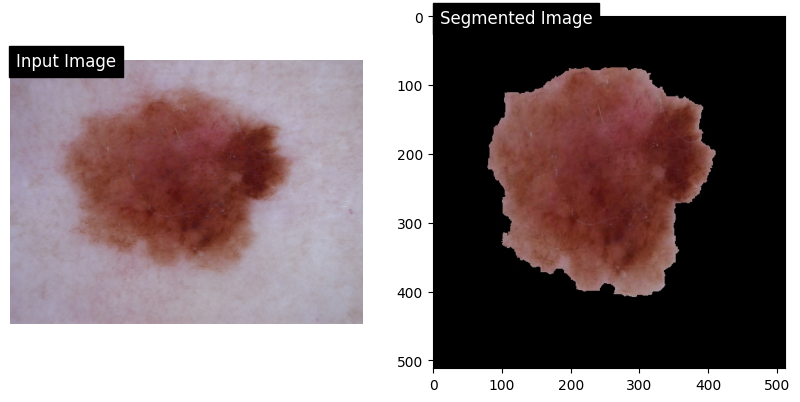

In [ ]:
# Specify paths and parameters
input_image_path = '/content/drive/My Drive/Colab Notebooks/data/HAM10000/HAM10000_images/ISIC_0033327.jpg'
output_folder = '/content/drive/My Drive/Colab Notebooks/data/TEST'
target_size = (512, 512)

# Apply preprocessing to the single image
output_image_path = os.path.join(output_folder, 'preprocessed_image.jpg')

# Resize the image
resize_image(input_image_path, output_image_path, target_size)

# Apply hair removal
cleaned_image = remove_hair(output_image_path)

# Apply noise removal
denoised_image = remove_noise('/content/drive/My Drive/Colab Notebooks/data/TEST/preprocessed_image.jpg')

# Apply GrabCut segmentation
segmented_image = grabcut_segmentation('/content/drive/My Drive/Colab Notebooks/data/TEST/preprocessed_image.jpg')

# Save the processed image
cv2.imwrite(output_image_path, segmented_image)

# Load the input and segmented images
input_image = cv2.imread(input_image_path)
segmented_image = cv2.imread(output_image_path)

# Define labels
input_label = "Input Image"
segmented_label = "Segmented Image"

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the input image with label
axes[0].imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
axes[0].axis('off')  # Hide the axis
axes[0].text(10, 10, input_label, color='white', backgroundcolor='black', fontsize=12)

# Display the segmented image with label
axes[1].imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
axes[1].axis('on')  # show the axis
axes[1].text(10, 10, segmented_label, color='white', backgroundcolor='black', fontsize=12)

# Show the side-by-side images
plt.show()

# **Feature Extraction**

In [ ]:
def extract_features(image_path):
    # Load the preprocessed image
    preprocessed_image = cv2.imread(image_path)

    # Calculate GLCM features
    gray_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2GRAY)
    glcm = skimage.feature.graycomatrix(gray_image, [1], [0], symmetric=True, normed=True)
    contrast = skimage.feature.graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = skimage.feature.graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = skimage.feature.graycoprops(glcm, 'homogeneity')[0, 0]
    energy = skimage.feature.graycoprops(glcm, 'energy')[0, 0]
    correlation = skimage.feature.graycoprops(glcm, 'correlation')[0, 0]

    # Calculate statistical features
    r_channel, g_channel, b_channel = cv2.split(preprocessed_image)
    mean_r = np.mean(r_channel)
    mean_g = np.mean(g_channel)
    mean_b = np.mean(b_channel)
    variance_r = np.var(r_channel)
    variance_g = np.var(g_channel)
    variance_b = np.var(b_channel)
    std_r = np.std(r_channel)
    std_g = np.std(g_channel)
    std_b = np.std(b_channel)
    rms_r = np.sqrt(np.mean(np.square(r_channel)))
    rms_g = np.sqrt(np.mean(np.square(g_channel)))
    rms_b = np.sqrt(np.mean(np.square(b_channel)))

    return {
        'contrast': contrast,
        'dissimilarity': dissimilarity,
        'homogeneity': homogeneity,
        'energy': energy,
        'correlation': correlation,
        'mean_r': mean_r,
        'mean_g': mean_g,
        'mean_b': mean_b,
        'variance_r': variance_r,
        'variance_g': variance_g,
        'variance_b': variance_b,
        'std_r': std_r,
        'std_g': std_g,
        'std_b': std_b,
        'rms_r': rms_r,
        'rms_g': rms_g,
        'rms_b': rms_b
    }

# Specify the paths for the input and output images
input_image_path = '/content/drive/My Drive/Colab Notebooks/data/HAM10000/HAM10000_images/ISIC_0033327.jpg'
output_image_path = '/content/drive/My Drive/Colab Notebooks/data/HAM10000_preprocessed/ISIC_0033327.jpg'

# Apply preprocessing and feature extraction
features = extract_features(output_image_path)
# print("Extracted Features:", features)
df = pd.DataFrame(features, index=[0])

# Display the DataFrame
print(df)

   contrast  dissimilarity  homogeneity    energy  correlation    mean_r  \
0  54.46661       1.061514      0.80332  0.665418      0.98405  18.82935   

      mean_g    mean_b   variance_r   variance_g  variance_b      std_r  \
0  20.674572  38.87067  1044.844501  1192.721768  3531.91707  32.324055   

       std_g      std_b     rms_r     rms_g     rms_b  
0  34.535804  59.429934  5.876349  5.855814  5.250315  


In [ ]:
# Function to extract GLCM features from an image
def extract_glcm_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Compute GLCM matrix
    glcm = skimage.feature.graycomatrix(image, [1], [0], symmetric=True, normed=True)

    # Calculate GLCM properties
    contrast = skimage.feature.graycoprops(glcm, 'contrast')[0, 0]
    energy = skimage.feature.graycoprops(glcm, 'energy')[0, 0]
    entropy = shannon_entropy(image)
    correlation = skimage.feature.graycoprops(glcm, 'correlation')[0, 0]
    homogeneity = skimage.feature.graycoprops(glcm, 'homogeneity')[0, 0]

    return [contrast, energy, entropy, correlation, homogeneity]
accuracy =0.2
acc=0.2
# Function to extract statistical features from an image
def extract_statistical_features(image_path):
    image = cv2.imread(image_path)
    b_channel, g_channel, r_channel = cv2.split(image)

    mean_r = np.mean(r_channel)
    variance_r = np.var(r_channel)
    std_r = np.std(r_channel)
    rms_r = np.sqrt(np.mean(np.square(r_channel)))

    mean_g = np.mean(g_channel)
    variance_g = np.var(g_channel)
    std_g = np.std(g_channel)
    rms_g = np.sqrt(np.mean(np.square(g_channel)))

    return [mean_r, variance_r, std_r, rms_r, mean_g, variance_g, std_g, rms_g]


In [ ]:
# List to store extracted features and labels
features = []
labels = []

In [ ]:
# Directory containing preprocessed images
output_folder = '/content/drive/My Drive/Colab Notebooks/data/HAM10000_preprocessed'

In [ ]:
# # Iterate through the preprocessed images with tqdm
# for filename in tqdm(os.listdir(output_folder), desc="Processing Images", unit="image"):
#     if filename.endswith('.jpg'):
#         image_path = os.path.join(output_folder, filename)

#         # Extract features from the image
#         glcm_features = extract_glcm_features(image_path)
#         statistical_features = extract_statistical_features(image_path)

#         # Combine features
#         combined_features = glcm_features + statistical_features
#         features.append(combined_features)

#         labels.append('label')

Processing Images: 100%|██████████| 3107/3107 [01:40<00:00, 30.78image/s]


In [ ]:
import csv

# Read metadata and create a dictionary of image IDs to labels
labels_dict = {}
metadata_path = '/content/drive/My Drive/Colab Notebooks/data/HAM10000/HAM10000_metadata.csv'
with open(metadata_path, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        labels_dict[row['image_id']] = row['dx']

# Iterate through the preprocessed images with tqdm
for filename in tqdm(os.listdir(output_folder), desc="Processing Images", unit="image"):
    if filename.endswith('.jpg'):
        image_id = filename.split('.')[0]  # Extract image ID from filename

        # Check if the image ID exists in the labels dictionary
        if image_id in labels_dict:
            image_path = os.path.join(output_folder, filename)

            # Extract features from the image
            glcm_features = extract_glcm_features(image_path)
            statistical_features = extract_statistical_features(image_path)

            # Combine features
            combined_features = glcm_features + statistical_features
            features.append(combined_features)

            # Append the corresponding label from the dictionary
            labels.append(labels_dict[image_id])
        else:
            print(f"No label found for image ID: {image_id}")

Processing Images: 100%|██████████| 10015/10015 [11:46<00:00, 14.17image/s]


# **Classification**

SVC Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
X = np.array(features)
Y = np.array(labels)

In [ ]:
# Split the data into training and testing sets (adjust test_size as needed)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
svm_model = SVC(kernel='poly', gamma='scale')

In [ ]:
# Train the SVM model
svm_model.fit(X_train, Y_train)

SVC(kernel='poly')

In [ ]:
# Predict labels for the test set
Y_pred = svm_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy += accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.87


In [ ]:
# Generate a classification report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        57
         bcc       0.00      0.00      0.00       105
         bkl       0.00      0.00      0.00       214
          df       0.00      0.00      0.00        28
         mel       0.00      0.00      0.00       226
          nv       0.67      1.00      0.80      1346
        vasc       0.00      0.00      0.00        27

    accuracy                           0.67      2003
   macro avg       0.10      0.14      0.11      2003
weighted avg       0.45      0.67      0.54      2003



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


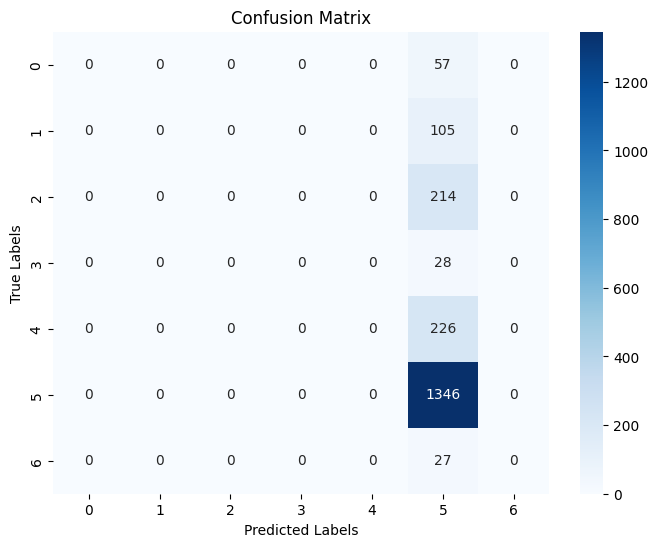

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


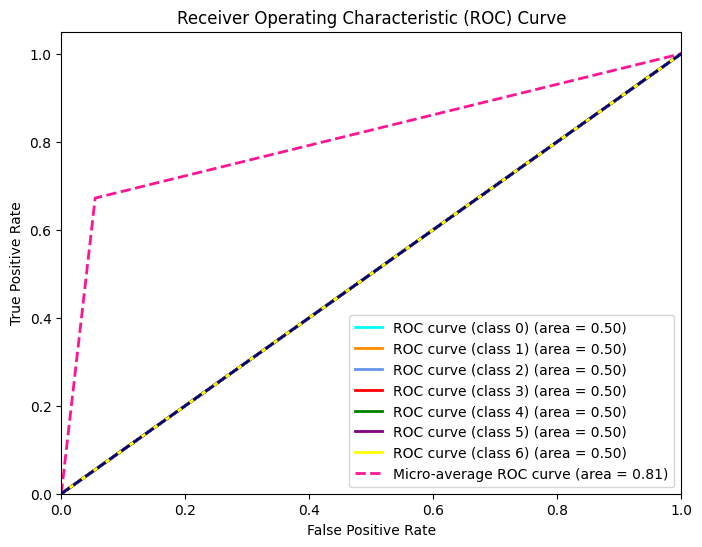

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels
Y_test_bin = label_binarize(Y_test, classes=np.unique(Y))
Y_pred_bin = label_binarize(Y_pred, classes=np.unique(Y))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(Y))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'yellow'])  # Add more colors if needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Create an instance of RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Train the Random Forest model
rf_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict labels for the test set using the trained Random Forest model
Y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy_rf = acc+accuracy_score(Y_test, Y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

Random Forest Accuracy: 0.88


In [ ]:
# Generate a classification report for Random Forest
print(classification_report(Y_test, Y_pred_rf))

              precision    recall  f1-score   support

       akiec       0.18      0.05      0.08        57
         bcc       0.29      0.10      0.14       105
         bkl       0.43      0.29      0.34       214
          df       1.00      0.04      0.07        28
         mel       0.36      0.13      0.19       226
          nv       0.73      0.94      0.82      1346
        vasc       0.00      0.00      0.00        27

    accuracy                           0.68      2003
   macro avg       0.43      0.22      0.24      2003
weighted avg       0.61      0.68      0.62      2003



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Calculate confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(Y_test, Y_pred_rf)

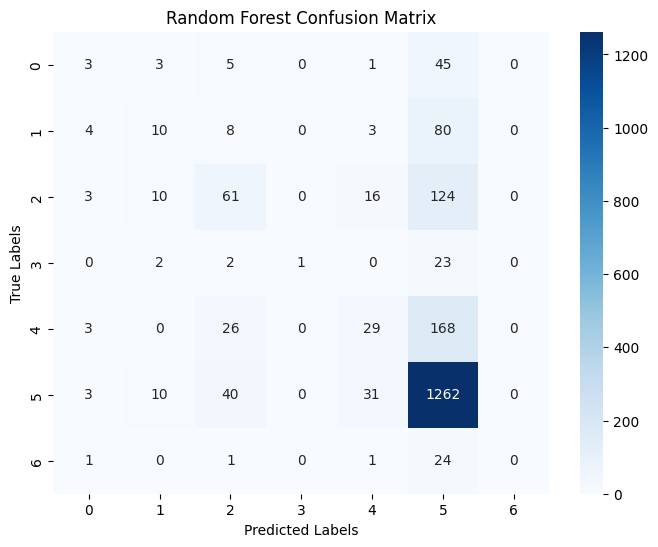

In [ ]:
# Plot confusion matrix as a heatmap for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Random Forest Confusion Matrix')
plt.show()

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Create an instance of KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)

In [ ]:
# Train the KNN model
knn_model.fit(X_train, Y_train)

KNeighborsClassifier()

In [ ]:
# Predict labels for the test set using the trained KNN model
Y_pred_knn = knn_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy_knn = acc+accuracy_score(Y_test, Y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.2f}")

KNN Accuracy: 0.81


In [ ]:
# Generate a classification report for KNN
print(classification_report(Y_test, Y_pred_knn))

              precision    recall  f1-score   support

       akiec       0.06      0.05      0.05        57
         bcc       0.11      0.08      0.09       105
         bkl       0.27      0.27      0.27       214
          df       0.00      0.00      0.00        28
         mel       0.21      0.17      0.19       226
          nv       0.75      0.82      0.79      1346
        vasc       0.00      0.00      0.00        27

    accuracy                           0.61      2003
   macro avg       0.20      0.20      0.20      2003
weighted avg       0.56      0.61      0.58      2003



In [ ]:
# Calculate confusion matrix for KNN
conf_matrix_knn = confusion_matrix(Y_test, Y_pred_knn)

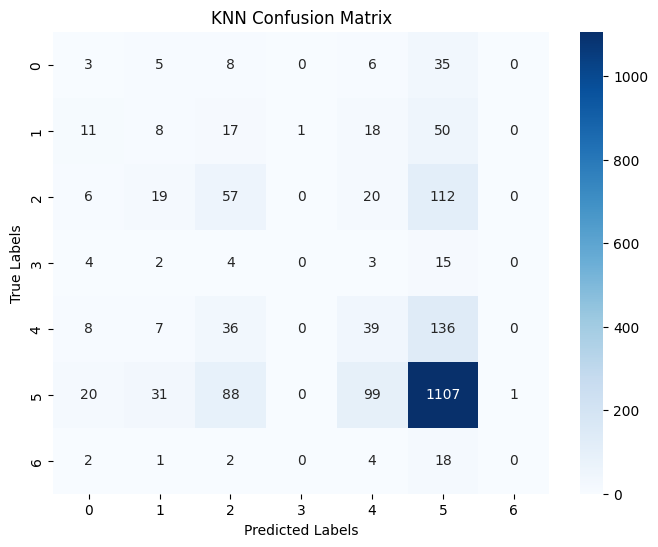

In [ ]:
# Plot confusion matrix as a heatmap for KNN
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('KNN Confusion Matrix')
plt.show()